In [49]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import urllib3
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm

Initial length: 10067
FDR: 0.0
Final length: 168


,sequence,spectrumID,chargeState,rank,passThreshold,experimentalMassToCharge,calculatedMassToCharge,peptideRef,modNum,isDecoy,...,MS.GF.EValue,MS.GF.QValue,MS.GF.PepQValue,modPeptideRef,modName,modMass,modLocation,subOriginalResidue,subReplacementResidue,subLocation
0,QLEAEKMELQSALEEAEASLEHEEGK,index=978,3,1,True,976.453613,976.453552,Pep_[-17QLEAEKM+16ELQSALEEAEASLEHEEGK,2,False,...,2.883160e-17,0.0,0.0,Pep_[-17QLEAEKM+16ELQSALEEAEASLEHEEGK,Gln->pyro-Glu,-17.026549,0.0,NaN,NaN,NaN
107,KAITDAAMMAEELKK,index=804,3,1,True,561.288086,561.288147,Pep_KAITDAAM+16M+16AEELKK,2,False,...,1.450279e-06,0.0,0.0,Pep_KAITDAAM+16M+16AEELKK,Oxidation,15.994915,8.0,NaN,NaN,NaN
108,KAITDAAMMAEELKK,index=804,3,1,True,561.288086,561.288147,Pep_KAITDAAM+16M+16AEELKK,2,False,...,1.450279e-06,0.0,0.0,Pep_KAITDAAM+16M+16AEELKK,Oxidation,15.994915,9.0,NaN,NaN,NaN
109,KAITDAAMMAEELKK,index=804,3,1,True,561.288086,561.288147,Pep_KAITDAAM+16M+16AEELKK,2,False,...,1.450279e-06,0.0,0.0,Pep_KAITDAAM+16M+16AEELKK,Oxidation,15.994915,8.0,NaN,NaN,NaN
110,KAITDAAMMAEELKK,index=804,3,1,True,561.288086,561.288147,Pep_KAITDAAM+16M+16AEELKK,2,False,...,1.450279e-06,0.0,0.0,Pep_KAITDAAM+16M+16AEELKK,Oxidation,15.994915,9.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,AMGIMNSFVNDIFER,index=664,2,1,True,888.408752,888.408203,Pep_AM+16GIM+16NSFVNDIFER,2,False,...,2.502414e-10,0.0,0.0,Pep_AM+16GIM+16NSFVNDIFER,Oxidation,15.994915,2.0,NaN,NaN,NaN
57,AMGIMNSFVNDIFER,index=664,2,1,True,888.408752,888.408203,Pep_AM+16GIM+16NSFVNDIFER,2,False,...,2.502414e-10,0.0,0.0,Pep_AM+16GIM+16NSFVNDIFER,Oxidation,15.994915,5.0,NaN,NaN,NaN
58,AMGIMNSFVNDIFER,index=664,2,1,True,888.408752,888.408203,Pep_AM+16GIM+16NSFVNDIFER,2,False,...,2.502414e-10,0.0,0.0,Pep_AM+16GIM+16NSFVNDIFER,Oxidation,15.994915,2.0,NaN,NaN,NaN
52,AMGIMNSFVNDIFER,index=664,2,1,True,888.408752,888.408203,Pep_AM+16GIM+16NSFVNDIFER,2,False,...,2.502414e-10,0.0,0.0,Pep_AM+16GIM+16NSFVNDIFER,Oxidation,15.994915,2.0,NaN,NaN,NaN


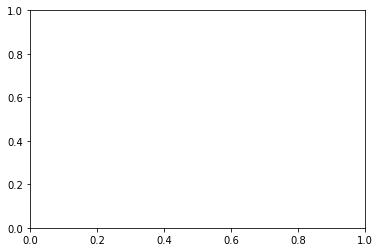

In [50]:
file = 'MSGF_v2/5000_batch_3.mzid.csv'
#file = 'MSGF/1000_v2_consensus.mzid.csv'
df = pd.read_csv(file)
print('Initial length:', len(df))

# Plot the score distribution for decoy = True and decoy = False
decoy = [False, True]
bins = np.linspace(0, 0.02, num=11)
fig, ax = plt.subplots()

def countDecoy(l):
    nTrue = sum(l)
    nFalse = len(l)-nTrue
    return nTrue, nFalse # nDecoy, nNotDecoy

# Only keep identifications for FDR < 0.01
df = df.sort_values(by='MS.GF.PepQValue') # Sort by Q value
df = df[df['MS.GF.PepQValue'] < 0.01]

nDecoy, nNotDecoy = countDecoy(df['isDecoy'])
FDR = nDecoy / (nDecoy+nNotDecoy)
print('FDR:', FDR)

# Only keep identifications for which isDecoy = False
df = df[df['isDecoy'] == False]
print('Final length:', len(df))
df

In [51]:
# Check how many spectra could be identified
print('Spectra that could be identified at 0.01 FDR: %d ' % (len(np.unique(df['spectrum.title'])),))

Spectra that could be identified at 0.01 FDR: 45 


In [52]:
def getUniprotDescription(accessionNum, http = urllib3.PoolManager()):
    r = http.request('GET', 'https://www.uniprot.org/uniprot/%s.xml' % (accessionNum,))
    root = ET.fromstring(r.data)
    for e in root.findall(".//{http://uniprot.org/uniprot}comment[@type='function']/{http://uniprot.org/uniprot}text"):
        return(e.text)

#prot_mod = df[['DatabaseDescription', 'spectrum.title', 'modName']]
http = urllib3.PoolManager()
descriptions = []
clids = []
tissues = []
uniprot_codes = []
uniprot_names = []
gene = []
qvalues = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    _, code, full_name = row['DatabaseDescription'].split('|')
    uniprot_codes.append(code)

    _, _, g = row['DatabaseAccess'].split('|')
    gene.append(g.split('_')[0])

    t = full_name.split(' OS')[0].split('HUMAN ')[1]
    uniprot_names.append(t)

    clids.append(row['spectrum.title'].split('_')[1])
    tissues.append(row['spectrum.title'].split(':')[1])

    descriptions.append(getUniprotDescription(code, http))
    #print(descriptions[-1])

    qvalues.append(row['MS.GF.PepQValue'])

    time.sleep(0.5)

  0%|          | 0/168 [00:00<?, ?it/s]

In [53]:
prot_mod = pd.DataFrame({'Cluster id': clids,
                         'Code': uniprot_codes,
                         'Gene': gene,
                         'PTM': df['modName'],
                         'Protein': uniprot_names,
                         'Tissue': tissues,
                         'Description': descriptions,
                         'Sequence': df['sequence'],
                         'Start': df['start'],
                         'End': df['end'],
                         'ModPeptideRef': df['modPeptideRef'],
                         'QValue': qvalues})
prot_mod = prot_mod.sort_values(by=['Cluster id', 'Protein'])
prot_mod.to_csv(file + '_descriptions.csv')

In [54]:
prot_mod

,Cluster id,Code,Gene,PTM,Protein,Tissue,Description,Sequence,Start,End,ModPeptideRef,QValue
2,1009346,Q8IWL2,SFTA1,Oxidation,Pulmonary surfactant-associated protein A1,Lung,"In presence of calcium ions, it binds to surfa...",GPPGLPAHLDEELQATLHDFR,95,115,Pep_GPP+16GLPAHLDEELQATLHDFR,0.0
3,1009346,Q8IWL1,SFPA2,Oxidation,Pulmonary surfactant-associated protein A2,Lung,"In presence of calcium ions, it binds to surfa...",GPPGLPAHLDEELQATLHDFR,95,115,Pep_GPP+16GLPAHLDEELQATLHDFR,0.0
4,1017386,P12883,MYH7,Oxidation,Myosin-7,Heart,Myosins are actin-based motor molecules with A...,IEDMAMLTFLHEPAVLYNLK,87,106,Pep_IEDM+16AM+16LTFLHEPAVLYNLK,0.0
5,1017386,P12883,MYH7,Oxidation,Myosin-7,Heart,Myosins are actin-based motor molecules with A...,IEDMAMLTFLHEPAVLYNLK,87,106,Pep_IEDM+16AM+16LTFLHEPAVLYNLK,0.0
64,1028957,P05023,AT1A1,Gln->pyro-Glu,Sodium/potassium-transporting ATPase subunit a...,Frontalcortex,This is the catalytic component of the active ...,QAADMILLDDNFASIVTGVEEGR,744,766,Pep_[-17QAADM+16ILLDDNFASIVTGVEEGR,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17,957282,P12883,MYH7,Oxidation,Myosin-7,Heart,Myosins are actin-based motor molecules with A...,MEGDLNEMEIQLSHANR,1618,1634,Pep_M+16EGDLNEM+16EIQLSHANR,0.0
86,979186,P13533,MYH6,Oxidation,Myosin-6,Heart,Muscle contraction.,KMEGDLNEMEIQLSHANR,1619,1636,Pep_KM+16EGDLNEM+16EIQLSHANR,0.0
87,979186,P13533,MYH6,Oxidation,Myosin-6,Heart,Muscle contraction.,KMEGDLNEMEIQLSHANR,1619,1636,Pep_KM+16EGDLNEM+16EIQLSHANR,0.0
88,979186,P12883,MYH7,Oxidation,Myosin-7,Heart,Myosins are actin-based motor molecules with A...,KMEGDLNEMEIQLSHANR,1617,1634,Pep_KM+16EGDLNEM+16EIQLSHANR,0.0


In [55]:
PTMs = []

# Check how many of each PTM there are
for id in np.unique(prot_mod['Cluster id'].astype(str)):
    PTMs = PTMs + list(set(prot_mod[prot_mod['Cluster id']==id]['PTM'].astype(str)))

print(Counter(PTMs))

Counter({'Oxidation': 33, 'Carbamidomethyl': 8, 'Phospho': 5, 'Methyl': 4, 'Gln->pyro-Glu': 3, 'Glu->pyro-Glu': 3, 'Acetyl': 2, 'Deamidated': 2, 'nan': 1})
